### Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### Load the Modeling Datset

In [26]:
df = pd.read_csv("../data/modeling_dataset.csv")
df.head()


,ticker,date,sector,close,sma_200,ema_12,volume_ratio,volume_sma_20,rsi_14,macd_histogram,price_to_sma_50,momentum_10,momentum_20,volatility_20,atr_14,true_range,trend_label
0,STK001,2021-01-04,Technology,160.11,160.110000,160.110000,1.000000,962644.00,100.000000,0.000000,0.000000,-0.008557,-0.045594,0.012463,2.880,2.88,Uptrend
1,STK001,2021-01-05,Technology,162.36,161.235000,160.456154,1.153842,1137664.50,100.000000,0.143590,0.006977,-0.008557,-0.045594,0.012463,4.135,5.39,Sideways
2,STK001,2021-01-06,Technology,161.78,161.416667,160.659822,1.167277,1241502.00,79.505300,0.188720,0.002251,-0.008557,-0.045594,0.012463,3.280,1.57,Sideways
3,STK001,2021-01-07,Technology,167.07,162.830000,161.646004,1.167320,1314834.75,92.857143,0.543952,0.026039,-0.008557,-0.045594,0.018138,3.990,6.12,Downtrend
4,STK001,2021-01-08,Technology,165.68,163.400000,162.266618,0.694431,1221520.00,79.284963,0.647386,0.013953,-0.008557,-0.045594,0.018663,4.008,4.08,Downtrend


In [27]:
df.shape

(15500, 17)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticker           15500 non-null  object 
 1   date             15500 non-null  object 
 2   sector           15500 non-null  object 
 3   close            15500 non-null  float64
 4   sma_200          15500 non-null  float64
 5   ema_12           15500 non-null  float64
 6   volume_ratio     15500 non-null  float64
 7   volume_sma_20    15500 non-null  float64
 8   rsi_14           15500 non-null  float64
 9   macd_histogram   15500 non-null  float64
 10  price_to_sma_50  15500 non-null  float64
 11  momentum_10      15500 non-null  float64
 12  momentum_20      15500 non-null  float64
 13  volatility_20    15500 non-null  float64
 14  atr_14           15500 non-null  float64
 15  true_range       15500 non-null  float64
 16  trend_label      15500 non-null  object 
dtypes: float64(1

In [29]:
# To change date to pandas datetime

df['date'] = pd.to_datetime(df['date'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ticker           15500 non-null  object        
 1   date             15500 non-null  datetime64[ns]
 2   sector           15500 non-null  object        
 3   close            15500 non-null  float64       
 4   sma_200          15500 non-null  float64       
 5   ema_12           15500 non-null  float64       
 6   volume_ratio     15500 non-null  float64       
 7   volume_sma_20    15500 non-null  float64       
 8   rsi_14           15500 non-null  float64       
 9   macd_histogram   15500 non-null  float64       
 10  price_to_sma_50  15500 non-null  float64       
 11  momentum_10      15500 non-null  float64       
 12  momentum_20      15500 non-null  float64       
 13  volatility_20    15500 non-null  float64       
 14  atr_14           15500 non-null  float

### Define Features and Target

In [31]:
target_col = 'trend_label'

# To exclude non-predictive columns
feature_cols = [col for col in df.columns if col not in ['ticker', 'date', target_col]]

print("Number of features:", len(feature_cols))
print("Sample features:", feature_cols[:10])


Number of features: 14
Sample features: ['sector', 'close', 'sma_200', 'ema_12', 'volume_ratio', 'volume_sma_20', 'rsi_14', 'macd_histogram', 'price_to_sma_50', 'momentum_10']


### Train-Test Split

In [32]:
# Temporal Split: 70% Train, 30% Test

split_date = df['date'].quantile(0.7)
train_df = df[df['date'] <= split_date].copy()
test_df  = df[df['date'] > split_date].copy()

print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)
print("Split date threshold:", split_date)

Training shape: (10860, 17)
Testing shape: (4640, 17)
Split date threshold: 2023-02-01 00:00:00


### Observation of Findings

The final modeling dataset retains ticker and date columns to preserve traceability and temporal context during the train-test split.

The date column ensures that chronological order is maintained during the 70/30 temporal split, preventing data leakage.

The ticker column allows post-modeling analysis by company and supports potential sectoral comparisons.

Both columns will be excluded before model training but are retained in the preparation stage for reproducibility and transparency.

### Train-Test Split Statistics

In [33]:
# Record counts and date ranges
train_start, train_end = train_df['date'].min(), train_df['date'].max()
test_start, test_end = test_df['date'].min(), test_df['date'].max()

print(f"Train period: {train_start.date()} - {train_end.date()}  ({len(train_df)} records)")
print(f"Test period:  {test_start.date()} - {test_end.date()}  ({len(test_df)} records)")

# Class distribution in train and test
print("\nTrain class distribution:")
print(train_df['trend_label'].value_counts(normalize=True).round(3))

print("\nTest class distribution:")
print(test_df['trend_label'].value_counts(normalize=True).round(3))


Train period: 2021-01-04 - 2023-02-01  (10860 records)
Test period:  2023-02-02 - 2023-12-22  (4640 records)

Train class distribution:
trend_label
Uptrend      0.352
Downtrend    0.338
Sideways     0.310
Name: proportion, dtype: float64

Test class distribution:
trend_label
Uptrend      0.368
Sideways     0.340
Downtrend    0.292
Name: proportion, dtype: float64


### Observation of Findings

The class proportions are consistent across training and testing sets.

There is no major imbalance, meaning all three market states (Uptrend, Sideways, and Downtrend) are well represented.

Minor differences are expected due to time variation in market behavior but remain within acceptable limits (<5%).

### Encode Categorical Data

In [34]:
sector_encoder = LabelEncoder()
train_df['sector'] = sector_encoder.fit_transform(train_df['sector'])
test_df['sector']  = sector_encoder.transform(test_df['sector'])

In [35]:
target_encoder = LabelEncoder()
train_df['trend_label'] = target_encoder.fit_transform(train_df['trend_label'])
test_df['trend_label']  = target_encoder.transform(test_df['trend_label'])

### Observation of Findings

The target variable - trend_label (Uptrend, Downtrend, Sideways) and sector are categorical.
A LabelEncoder was used to convert these categories into numerical class labels.

- The encoder was fitted on the training labels only

- The learned mapping was then applied to the test labels

This preserves temporal integrity and avoids leakage.

### Scale Numerical features

In [36]:
# Define numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns


### Observation of Findings

All numerical indicator columns (e.g., SMA, EMA, MACD, ATR, RSI, volatility, momentum) were automatically detected using select_dtypes. These features require scaling to ensure uniform magnitude across inputs.

In [37]:
# To check for skewness
df[num_cols].skew().sort_values()


macd_histogram    -0.347047
price_to_sma_50   -0.099034
rsi_14            -0.068735
volume_ratio       0.041914
momentum_10        0.084513
momentum_20        0.142503
volume_sma_20      0.154681
volatility_20      0.812356
sma_200            1.584413
ema_12             2.106573
close              2.157238
atr_14             2.250512
true_range         2.741416
dtype: float64

### Observation of Findings

A skewness check revealed that several features had moderate to strong positive skew (e.g., ATR, true range, SMA_200, EMA_12, close price). Financial indicators often display heavy-tailed distributions.

This informed the choice of scaler (RobustScaler)

In [38]:
num_cols

Index(['close', 'sma_200', 'ema_12', 'volume_ratio', 'volume_sma_20', 'rsi_14',
       'macd_histogram', 'price_to_sma_50', 'momentum_10', 'momentum_20',
       'volatility_20', 'atr_14', 'true_range'],
      dtype='object')

In [39]:
scaler = RobustScaler()

train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])


### Observation of Findings

Because of the presence of skewed distributions and outliers in the data, a RobustScaler was selected.
- scaler.fit_transform() applied to training features only
- scaler.transform() applied to test features

This preserves consistency between datasets.

### Build Logistic Regression Model

In [40]:
from sklearn.linear_model import LogisticRegression

X_train = train_df[num_cols]
y_train = train_df[target_col]

X_test = test_df[num_cols]
y_test = test_df[target_col]

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

preds = model.predict(X_test)

### Model Evaluation

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds, target_names=target_encoder.classes_))


Accuracy: 0.3747844827586207

Classification Report:
               precision    recall  f1-score   support

   Downtrend       0.35      0.21      0.27      1354
    Sideways       0.39      0.55      0.45      1579
     Uptrend       0.37      0.34      0.36      1707

    accuracy                           0.37      4640
   macro avg       0.37      0.37      0.36      4640
weighted avg       0.37      0.37      0.36      4640



### Predictable Trend Type

In [42]:
report = classification_report(y_test, preds, target_names=target_encoder.classes_, output_dict=True)
pd.DataFrame(report).T


,precision,recall,f1-score,support
Downtrend,0.349340,0.214919,0.266118,1354.000000
Sideways,0.385682,0.545915,0.452019,1579.000000
Uptrend,0.372774,0.343292,0.357426,1707.000000
accuracy,0.374784,0.374784,0.374784,0.374784
macro avg,0.369265,0.368042,0.358521,4640.000000
weighted avg,0.370328,0.374784,0.362972,4640.000000


### Result visualization

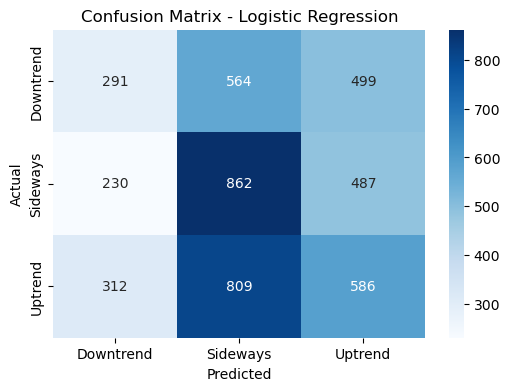

In [43]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")

plt.show()
